<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/UNet_Model_BraTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Image Segmentation with U-NET


In [ ]:
# Import libraries
import tarfile
import re
import imageio.v2 as iio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors
import scipy.ndimage
import textwrap

## Download the imaging dataset


In [ ]:
!gdown https://drive.google.com/uc?id=1nHZWlCBpudbT4zzPyqyu2Vi5uILcxSrv

# Assuming the downloaded file is a ZIP file and its name is 'downloaded_data.zip'
import zipfile
with zipfile.ZipFile('Slices.zip', 'r') as zip_ref:
    zip_ref.extractall()


Downloading...
From: https://drive.google.com/uc?id=1nHZWlCBpudbT4zzPyqyu2Vi5uILcxSrv
To: /content/Slices.zip
100% 56.1M/56.1M [00:00<00:00, 83.4MB/s]


# Implement a dataset class

It can read the imaging dataset and get items, pairs of images and label maps, as training batches.

Train Sample: 1395 Test Sample: 310


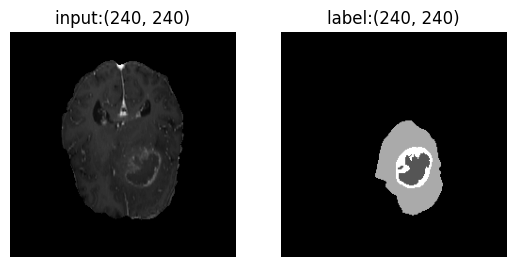

In [ ]:
from torch.utils.data import Dataset, DataLoader
from glob import glob
import imageio.v2 as iio
import matplotlib.pyplot as plt
from glob import glob
import numpy as np

def normalise_intensity(image, ROI_thres=0.1):
    pixel_thres = np.percentile(image, ROI_thres)
    ROI = np.where(image > pixel_thres, image, 0) # If image value is greater than pixel threshold, return image value, otherwise return 0
    mean = np.mean(ROI)
    std = np.std(ROI)
    ROI_norm = (ROI - mean) / (std + 1e-8) # Normalise ROI
    return ROI_norm

def map_labels(label):
    label_map = {0: 0, 85: 1, 170: 2, 255: 3}
    mapped_label = label.copy()
    for k, v in label_map.items():
        mapped_label[label == k] = v
    return mapped_label

class BratsDataset(Dataset):
    def __init__(self, root='brats_train'):
        self.img_path_all = glob(root + '/BraTS-GLI-t1c/*.png')
        self.mask_path_all = [img_path.replace('t1c', 'seg') for img_path in self.img_path_all]

    def __len__(self):
      return len(self.img_path_all)

    def __getitem__(self, index):
        image = iio.imread(self.img_path_all[index])
        image = normalise_intensity(image)
        label = iio.imread(self.mask_path_all[index])
        label = map_labels(label)
        return image, label

train_dataset = BratsDataset(root='Slices/Train')
test_dataset = BratsDataset(root='Slices/Test')
print('Train Sample:', len(train_dataset), 'Test Sample:', len(test_dataset))
input, label = test_dataset[3]
plt.subplot(1,2,1), plt.axis('OFF'), plt.title('input:{}'.format(input.shape)), plt.imshow(input, cmap='gray')
plt.subplot(1,2,2), plt.axis('OFF'), plt.title('label:{}'.format(label.shape)), plt.imshow(label, cmap='gray');

# Build a U-net architecture

You will implement a U-net architecture. If you are not familiar with U-net, please read this paper:

[1] Olaf Ronneberger et al. [U-Net: Convolutional networks for biomedical image segmentation](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28). MICCAI, 2015.


In [ ]:
class conv_block(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super().__init__()
    # Convolution layer, a ReLU activation to add non-linearity, and Batch Normalisation
    # Bias is set as false, as Batch Normalisation would remove the bias
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )
  def forward(self, x):
    return self.conv(x)

class UNet(nn.Module):
  # U-Net Model involves an encoder, a bottleneck and decoder section
  def __init__(self, num_classes=4):
    super().__init__()
    # Encoder with 4 blocks of Double_Convolution layers
    # Includes 4 sets of max pooling operations with kernel 2x2 and stride 2 for downsampling
    self.down_1 = nn.Sequential(
        conv_block(1, 16),
        conv_block(16, 16),
    )
    self.down_2 = nn.Sequential(
        conv_block(16, 32, 2),
        conv_block(32, 32),
    )
    self.down_3 = nn.Sequential(
        conv_block(32, 64, 2),
        conv_block(64, 64),
    )
    # Bottleneck
    # Includes a Double Convolution layer followed by upsampling with ConvTranspose2d
    self.bottle = nn.Sequential(
        conv_block(64, 128, 2),
        conv_block(128, 128),
        nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
    )

    # Decoder
    # Concatinating with skip connections causes feature channels to double
    # Double_Convolution and ConvTranspose2d each causes feature channels to halve
    self.up_1 = nn.Sequential(
        conv_block(128, 64),
        conv_block(64, 64),
        nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
    )
    self.up_2 = nn.Sequential(
        conv_block(64, 32),
        conv_block(32, 32),
        nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
    )
    # Final Output Layer
    self.out = nn.Sequential(
        conv_block(32, 16),
        conv_block(16, 16),
        nn.Conv2d(16, 4, kernel_size=1, padding=0)
    )

  def forward(self, x):
      # Use the convolutional operators defined above to build the U-net
      # Encoder
      x1 = self.down_1(x)
      x2 = self.down_2(x1)
      x3 = self.down_3(x2)

      x4 = self.bottle(x3)

      # Decoder
      ### Insert your code ###
      x5 = torch.cat((x4, x3), dim=1)
      x6 = self.up_1(x5)
      x7 = torch.cat((x6, x2), dim=1)
      x8 = self.up_2(x7)
      x9 = torch.cat((x8, x1), dim=1)
      x10 = self.out(x9)
      return x10


In [ ]:
import os
import torch
import torch.optim as optim
import torch.nn as nn

def train_per_epoch(model, trainloader, loss_fn, optimizer):
    model.train()
    loss_per_epoch = []
    for batch_idx, (images, labels) in enumerate(trainloader):
        images, labels = images.unsqueeze(1).to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
        logits = model(images)
        optimizer.zero_grad() # Clear previous gradients
        loss = loss_fn(logits, labels) # Compute loss
        loss.backward() # Carry out backpropagation and calculate gradients
        optimizer.step() # Update model parameters
        loss_per_epoch.append(loss.item())

    return torch.tensor(loss_per_epoch).mean().item()

def test_per_epoch(model, testloader, loss_fn, optimizer):
    model.eval()
    loss_per_epoch = []
    with torch.no_grad():  # Disabling gradient calculation during reference to reduce memory consumption
        for batch_idx, (images, labels) in enumerate(testloader):
            images, labels = images.unsqueeze(1).to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
            logits = model(images)
            loss = loss_fn(logits, labels)
            loss_per_epoch.append(loss.item())

    return torch.tensor(loss_per_epoch).mean().item()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_classes=4
model = UNet(num_classes=num_classes)
model = model.to(device)

epochs = 120
train_batch_size = 25
eval_batch_size = 300


train_dataset = BratsDataset(root='Slices/Train')
test_dataset = BratsDataset(root='Slices/Test')

model_dir = 'saved_models'
os.makedirs(model_dir, exist_ok = True)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss(ignore_index=128)

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=eval_batch_size, shuffle=False, num_workers=2)
print('Training on:', device, 'train sample size:', len(train_dataset), 'test sample size:', len(test_dataset))

best_epoch, best_loss = 0.0, np.inf
for epoch in range(epochs):

    loss_training = train_per_epoch(model, train_loader, loss_fn, optimizer)
    loss_testing = test_per_epoch(model, test_loader, loss_fn, optimizer)

    # Save the best model
    if loss_testing < best_loss:
        best_loss = loss_testing
        best_epoch = epoch
        torch.save(model.state_dict(), os.path.join(model_dir, 'model_best.pt'))


    print('--- Epoch {}\{}: Training loss = {:.4f}, Testing loss = {:.4f}, Best loss = {:.4f}, Best epoch = {} '.\
            format(epoch, epochs, loss_training, loss_testing, best_loss, best_epoch))

Training on: cuda train sample size: 1395 test sample size: 310
--- Epoch 0\120: Training loss = 1.0080, Testing loss = 0.8056, Best loss = 0.8056, Best epoch = 0 
--- Epoch 1\120: Training loss = 0.6020, Testing loss = 0.4982, Best loss = 0.4982, Best epoch = 1 
--- Epoch 2\120: Training loss = 0.3469, Testing loss = 0.2988, Best loss = 0.2988, Best epoch = 2 
--- Epoch 3\120: Training loss = 0.2042, Testing loss = 0.1915, Best loss = 0.1915, Best epoch = 3 
--- Epoch 4\120: Training loss = 0.1314, Testing loss = 0.1328, Best loss = 0.1328, Best epoch = 4 
--- Epoch 5\120: Training loss = 0.0970, Testing loss = 0.1076, Best loss = 0.1076, Best epoch = 5 
--- Epoch 6\120: Training loss = 0.0758, Testing loss = 0.0955, Best loss = 0.0955, Best epoch = 6 
--- Epoch 7\120: Training loss = 0.0630, Testing loss = 0.0833, Best loss = 0.0833, Best epoch = 7 
--- Epoch 8\120: Training loss = 0.0543, Testing loss = 0.0832, Best loss = 0.0832, Best epoch = 8 
--- Epoch 9\120: Training loss = 0.0

Evaluation:

Test Sample: 310


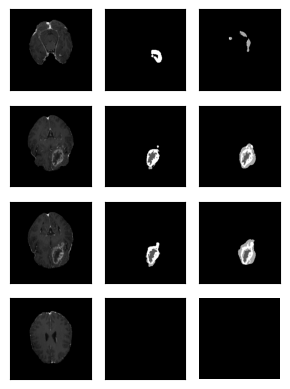

Class Wise Dice: {'dice_cls:1': 0.5027507125339696, 'dice_cls:2': 0.7297378627791895, 'dice_cls:3': 0.8159257873279105}
Overall Dice: 0.6828047875470232


In [ ]:
from torchmetrics import Dice
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

def calculate_confusion_matrix_from_arrays(prediction, ground_truth, nr_labels):
    replace_indices = np.vstack((
        ground_truth.flatten(),
        prediction.flatten())
    ).T
    confusion_matrix, _ = np.histogramdd(
        replace_indices,
        bins=(nr_labels, nr_labels),
        range=[(0, nr_labels), (0, nr_labels)]
    )
    confusion_matrix = confusion_matrix.astype(np.uint32)
    return confusion_matrix

def calculate_dice(confusion_matrix):
    dices = []
    for index in range(confusion_matrix.shape[0]):
        true_positives = confusion_matrix[index, index]
        false_positives = confusion_matrix[:, index].sum() - true_positives
        false_negatives = confusion_matrix[index, :].sum() - true_positives
        denom = 2 * true_positives + false_positives + false_negatives
        if denom == 0:
            dice = 0
        else:
            dice = 2 * float(true_positives) / denom
        dices.append(dice)
    return dices


def test_per_epoch(model, testloader):
    model.eval()
    fig, axs = plt.subplots(len(testloader), 3, figsize=(1*3, len(testloader)*1), subplot_kw=dict(xticks=[],yticks=[]))
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.uint32)
    class_wise_dice = []
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(testloader):
            images, labels = images.unsqueeze(1).to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
            logits = model(images)
            prob = F.softmax(logits, dim=1)
            pred_seg = torch.argmax(prob, dim=1)
            confusion_matrix += calculate_confusion_matrix_from_arrays(pred_seg.cpu(), labels.cpu(), num_classes)
            img_num = 0
            axs[batch_idx, 0].imshow(images[img_num, 0].cpu().numpy(), cmap='gray')
            axs[batch_idx, 1].imshow(labels[img_num].cpu().numpy(), cmap='gray')
            axs[batch_idx, 2].imshow(pred_seg[img_num].cpu().numpy(), cmap='gray')

    confusion_matrix = confusion_matrix[1:, 1:]  # exclude background
    dices_per_class = {'dice_cls:{}'.format(cls + 1): dice
                for cls, dice in enumerate(calculate_dice(confusion_matrix))}

    plt.axis('OFF')
    plt.tight_layout()
    plt.show()
    return dices_per_class

num_classes=4
model = UNet(num_classes=num_classes).to(device)
model.load_state_dict(torch.load('/content/saved_models/model_best.pt'))
eval_batch_size = 80
print('Test Sample:', len(test_dataset))
test_loader = DataLoader(test_dataset, batch_size=eval_batch_size, shuffle=False, num_workers=2)
dices_per_class = test_per_epoch(model, test_loader)
dices_per_class_list = np.array(list(dices_per_class.values()))
print('Class Wise Dice:', dices_per_class)
print('Overall Dice:', np.mean(dices_per_class_list))